In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils import load_data
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [67]:
# time series as x-axis, tough issue.. matplotlib go to hell...
def cal_perf(code, method, b_weight=[0,0.5,2/3,1], **params):
    ret_ls = pd.read_csv(r".\performances\{}_{}.csv".format(code, method), index_col = 0)
    df = {}
    param_name = list(params.keys())[0]
    params = list(params.values())[0]
    for j, b in enumerate(b_weight):
        for i, pv in enumerate(params):
            _ret_ls = np.array(ret_ls.loc[(ret_ls[param_name] == pv)&(ret_ls.b_weight == b)].iloc[:,0])
            avg_return = _ret_ls.mean()
            cum_return = (_ret_ls + 1).prod() - 1
            annual_ex_return = (_ret_ls + 1).prod() ** (12 / len(_ret_ls)) - 1
            annual_vol = _ret_ls.std() * np.sqrt(12)
            annual_sharpe = annual_ex_return / annual_vol
            df[('%.2f' %b, "%.0f" %pv)] = [cum_return, annual_ex_return, annual_vol, annual_sharpe]
    df = pd.DataFrame.from_dict(df,orient="index",columns=["Cum.Ret", "Ann.Ret", "Ann.Vol", "Ann.Sharpe"])
    df.index = pd.MultiIndex.from_tuples(list(df.index), names=["b_weight", param_name])
    return df
    
def allocation_plot(sector_index, sectornames, country, code, lag, method, window=60, b_weight=[0.5, 2/3, 1], **params):
    df_sectors, p, T = load_data(sector_index, code)
    returns = df_sectors.iloc[window:, :p]
    plt.style.use('seaborn')
    
    perf = cal_perf(code, method, **params)
    
    param_name = list(params.keys())[0]
    params = list(params.values())[0]
    
    fig, axes = plt.subplots(
        figsize=(15*len(params), 6*len(params)), ncols=len(b_weight), nrows=len(params))
    weights = pd.read_csv(r".\weights\{}_{}.csv".format(code,method),index_col = 0)
    for i, pv in enumerate(params):
        for j, b in enumerate(b_weight):
            _weights = weights.loc[(weights[param_name] == pv)&(weights.b_weight == b)].iloc[:,:p]
            s1 = "{} = {:.0f}, w = {:.0%}\n \n".format(param_name, pv, b)
            _perf = perf.loc[('%.2f' %b, "%.0f" %pv)].to_list()
            s2 = "Cum. Return: {0:.2%} Ann. Ex Return: {1:.2%}\n Ann. Vol: {2:.2%} Ann. Sharpe: {3:.4f}".format(*_perf)
    #         weights.index = mdates.date2num(weights.index)
    #         axes[i].bar(x=weights.index,height=weights.iloc[:,0],color="r")
            _weights.plot(kind='bar', stacked=True, title=s1 + s2, colormap='Paired', ax=axes[i, j])
    #         axes[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth = 12))
    #         axes[i].xaxis.set_major_formatter(mdates.AutoDateLocator())
            axes[i, j].xaxis.set_major_locator(ticker.FixedLocator(
                locs=np.arange(lag, len(weights.index), 12)))
            axes[i, j].legend(sectornames, ncol=1, loc="center left", bbox_to_anchor=(
                1, 0.5), fontsize=11, shadow=False, fancybox=False)
            axes[i, j].set_xlabel("")
    fig.suptitle("Sector Allocation ({})".format(country), fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(".\plots\{}_allocation.png".format(code, b_weight))
    plt.show()

In [76]:
df = cal_perf("cn", "quadproge", gamma_op=[2, 4, 8])
display(df.style.format('{:.2%}'))
list(map(float, df["Ann.Sharpe"].idxmax()))

[1.0, 4.0]

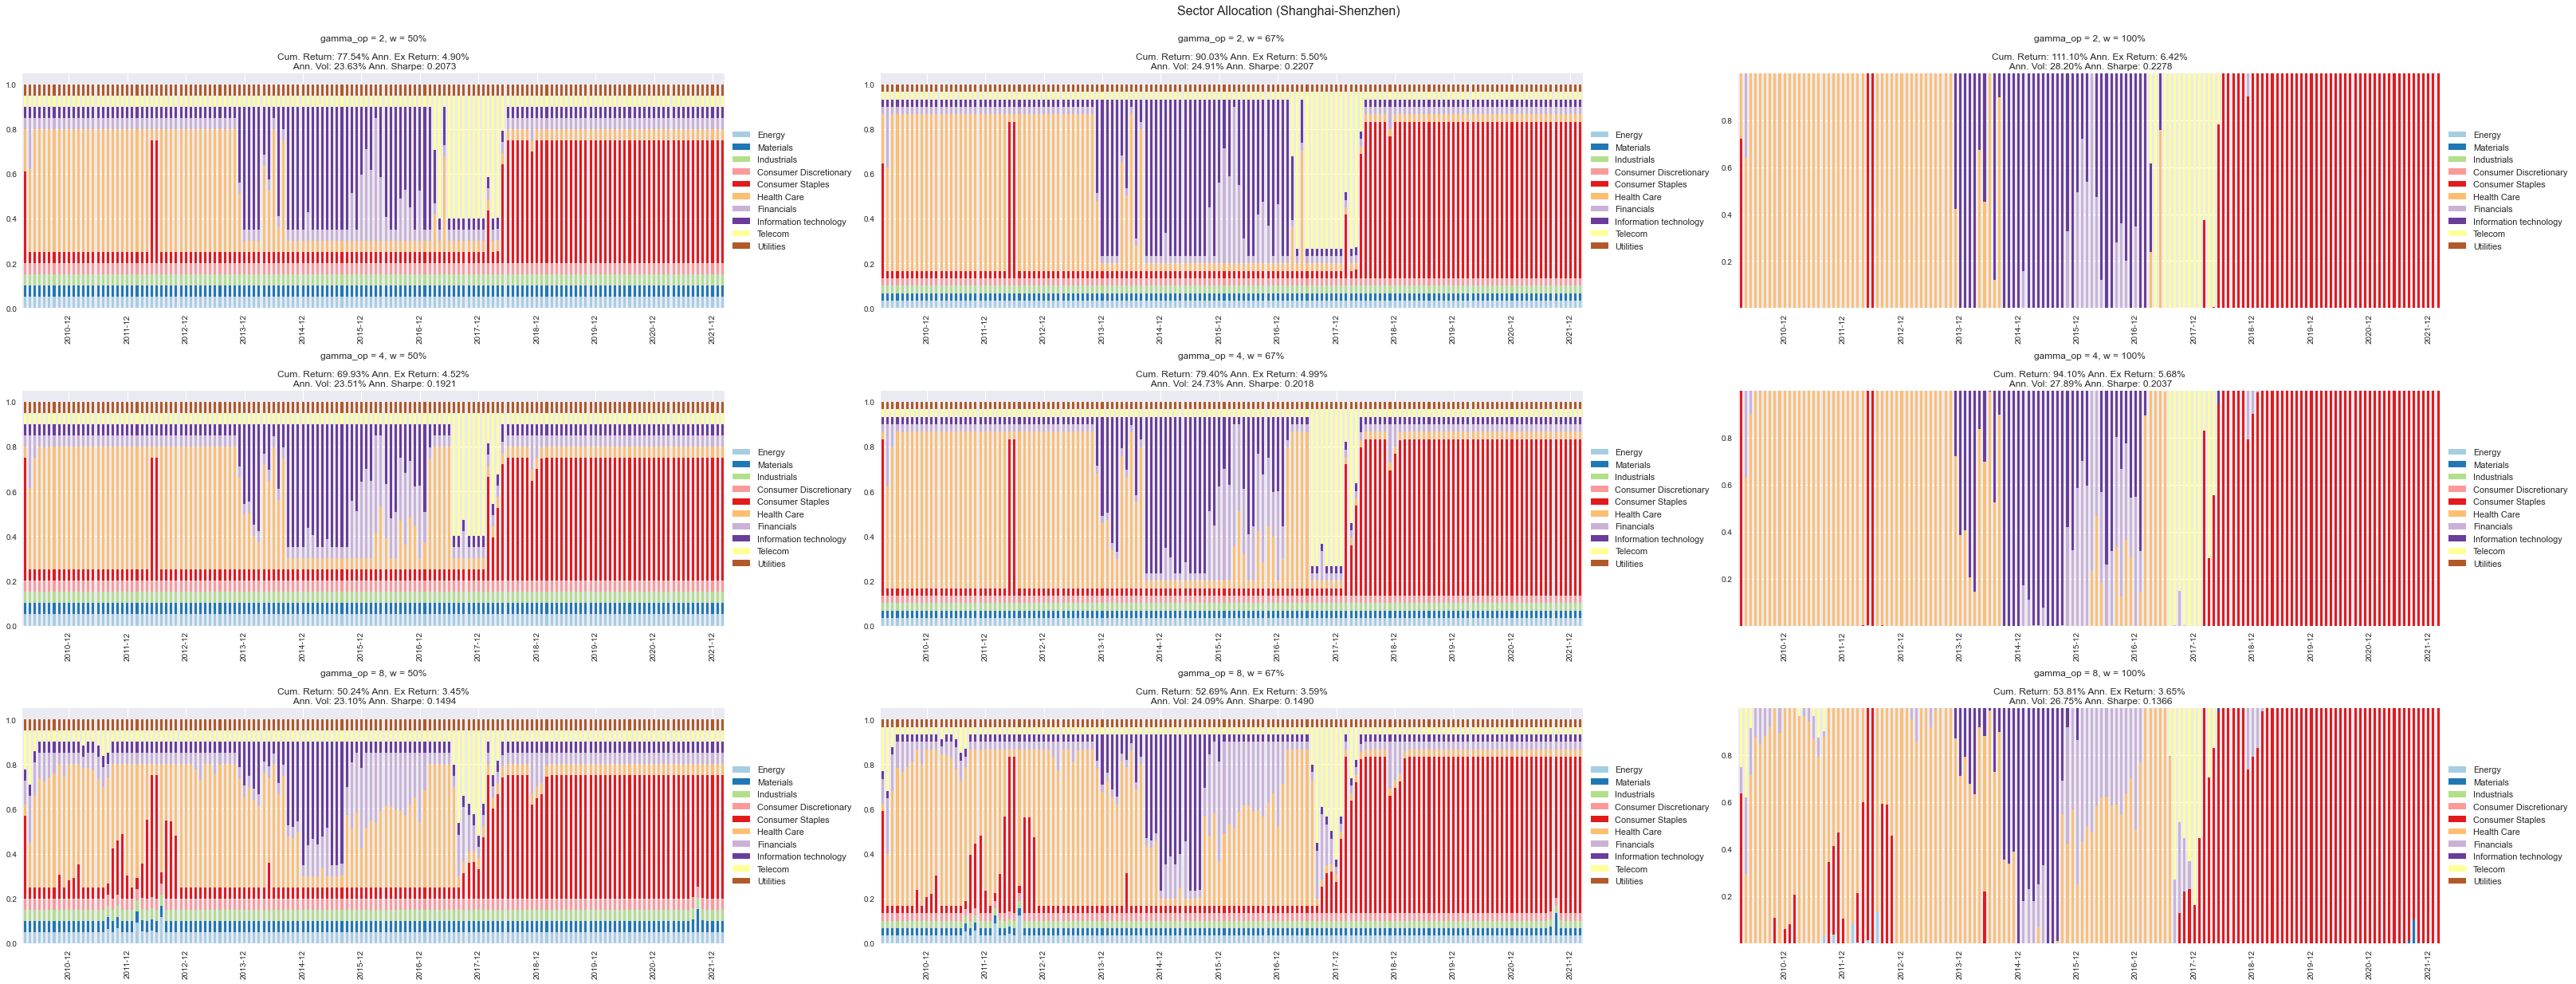

In [68]:
sectornames = ["Energy", "Materials", "Industrials", "Consumer Discretionary", "Consumer Staples", "Health Care", "Financials",
               "Information technology", "Telecom", "Utilities"]
allocation_plot("csi", sectornames, "Shanghai-Shenzhen", "cn", lag = 9, method = "quadprog", gamma_op=[2, 4, 8])

C:\Users\ARIZON~1\AppData\Local\Temp/ipykernel_13016/2088308826.py:12: RuntimeWarning: invalid value encountered in double_scalars
  annual_ex_return = (_ret_ls + 1).prod() ** (12 / len(_ret_ls)) - 1


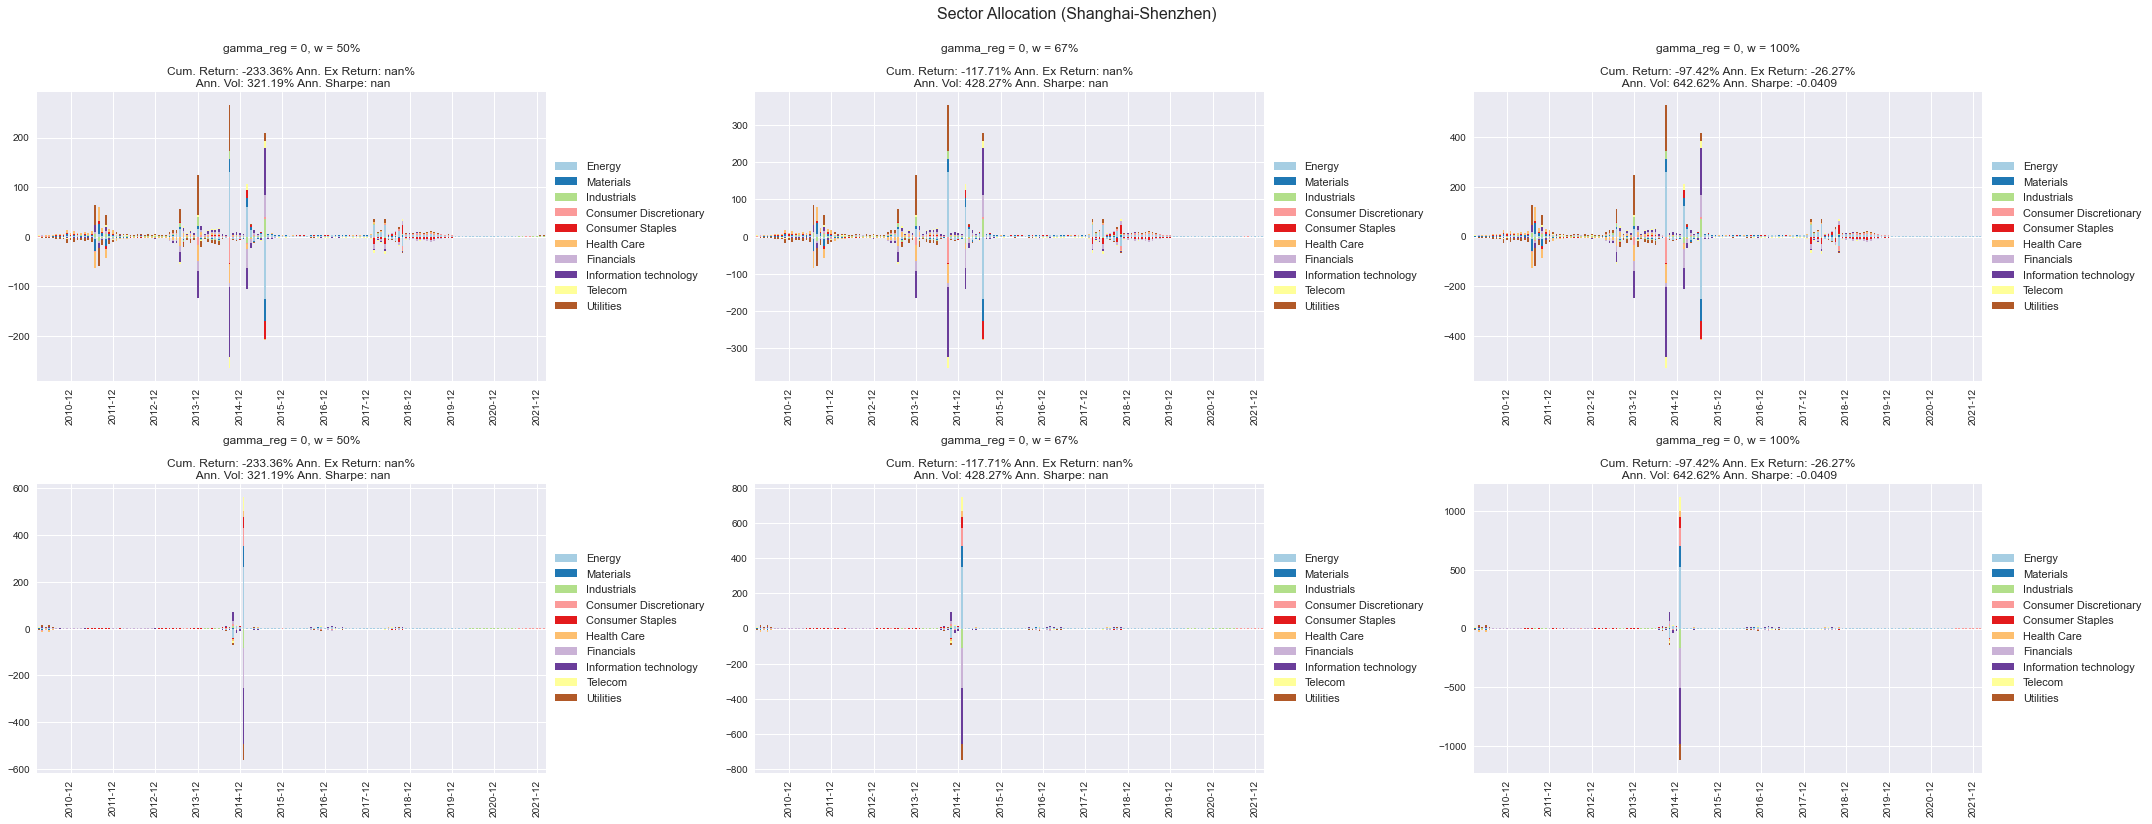

In [73]:
sectornames = ["Energy", "Materials", "Industrials", "Consumer Discretionary", "Consumer Staples", "Health Care", "Financials",
               "Information technology", "Telecom", "Utilities"]
allocation_plot("csi", sectornames, "Shanghai-Shenzhen", "cn", lag = 9, method = "formulae", gamma_reg=[0.001, 0.0001])

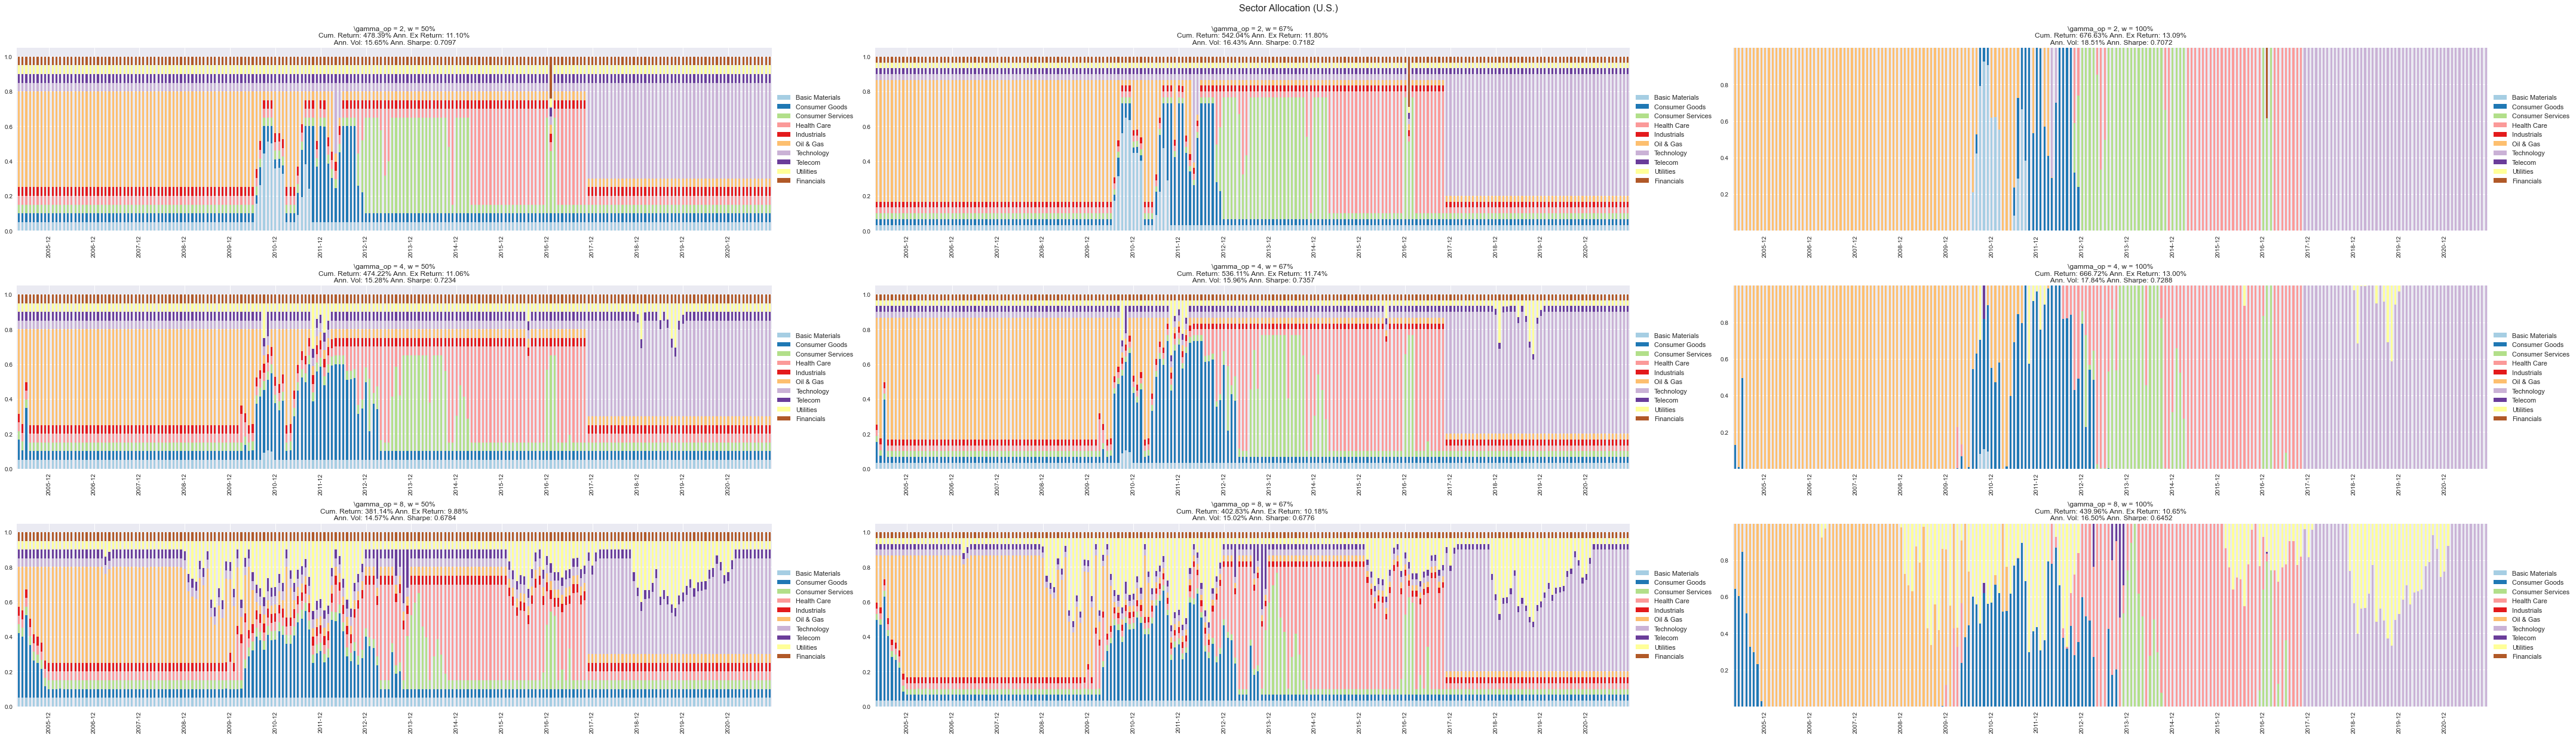

In [24]:
sectornames = ["Basic Materials", "Consumer Goods", "Consumer Services", "Health Care", "Industrials", "Oil & Gas", 
              "Technology", "Telecom", "Utilities", "Financials"]
allocation_plot("dj", sectornames, "U.S.", "us", lag = 8, gamma_op=[2, 4, 8])

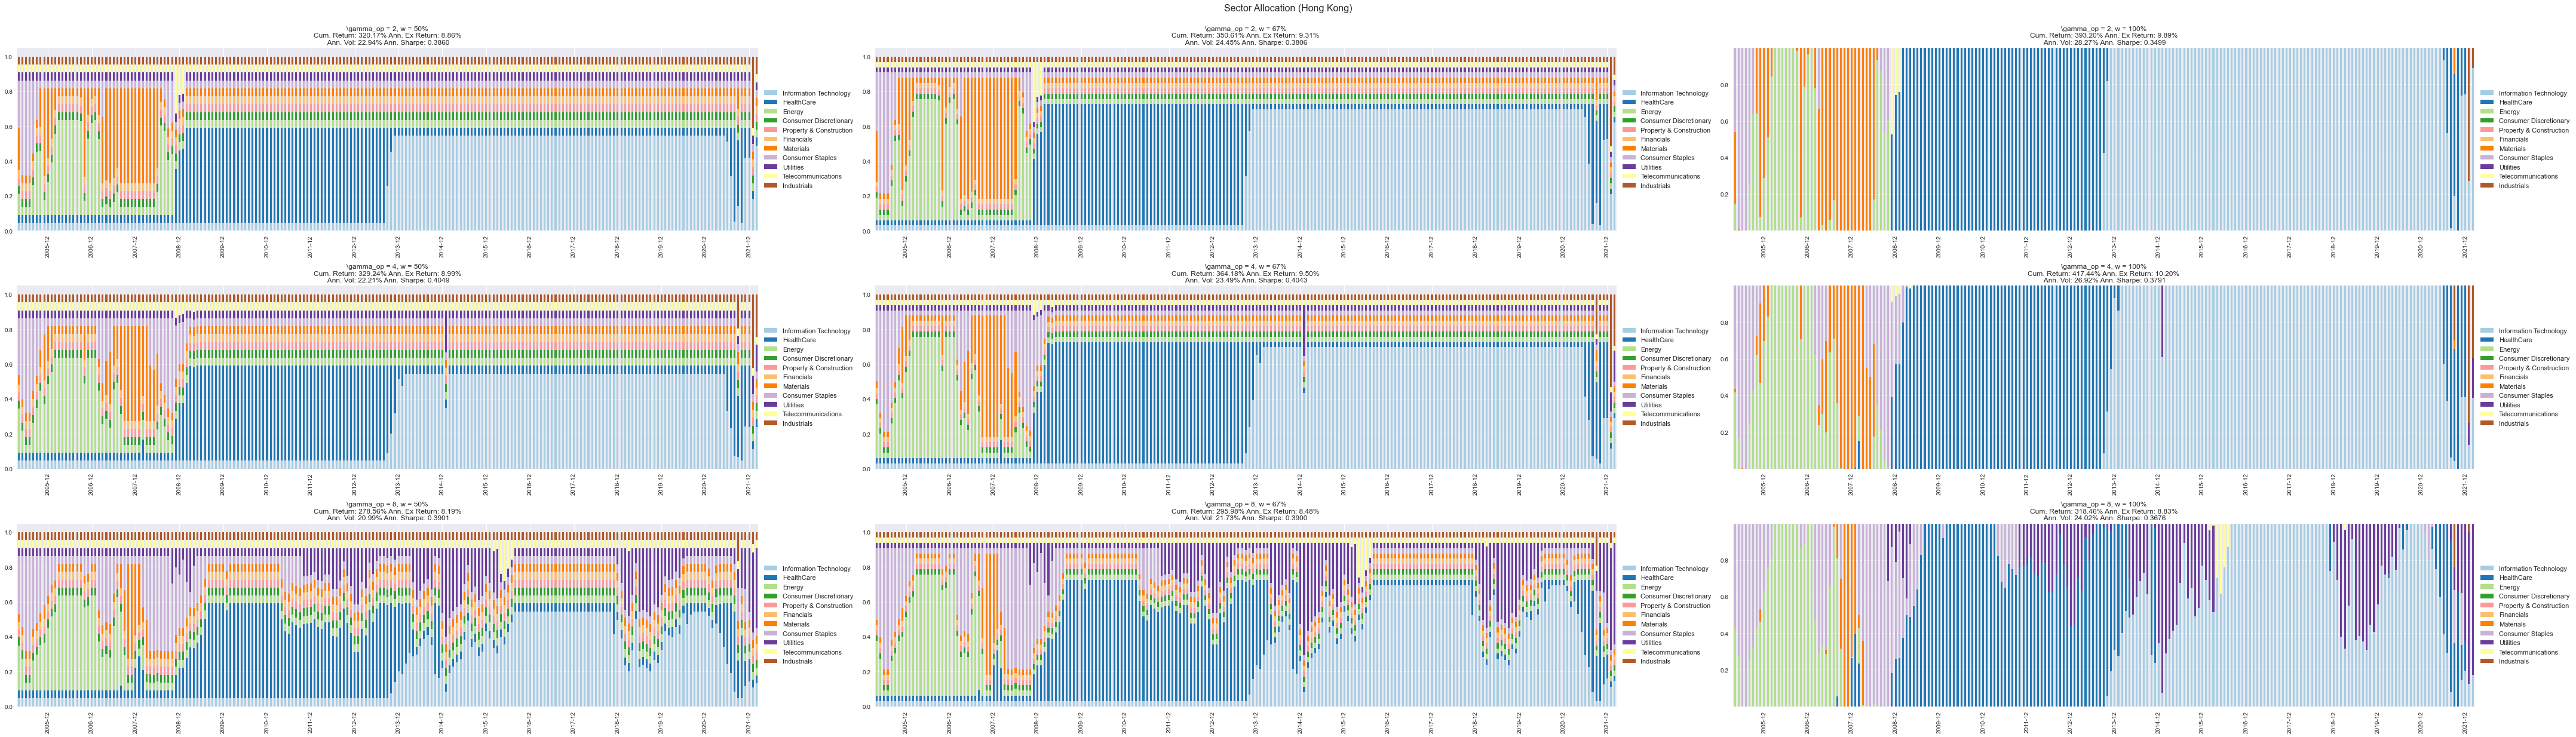

In [27]:
sectornames = ["Information Technology", "HealthCare", "Energy", "Consumer Discretionary", "Property & Construction", "Financials","Materials",
              "Consumer Staples", "Utilities", "Telecommunications", "Industrials"]
allocation_plot("hsci", sectornames, "Hong Kong", "hk", lag = 8, gamma_op=[2, 4, 8])

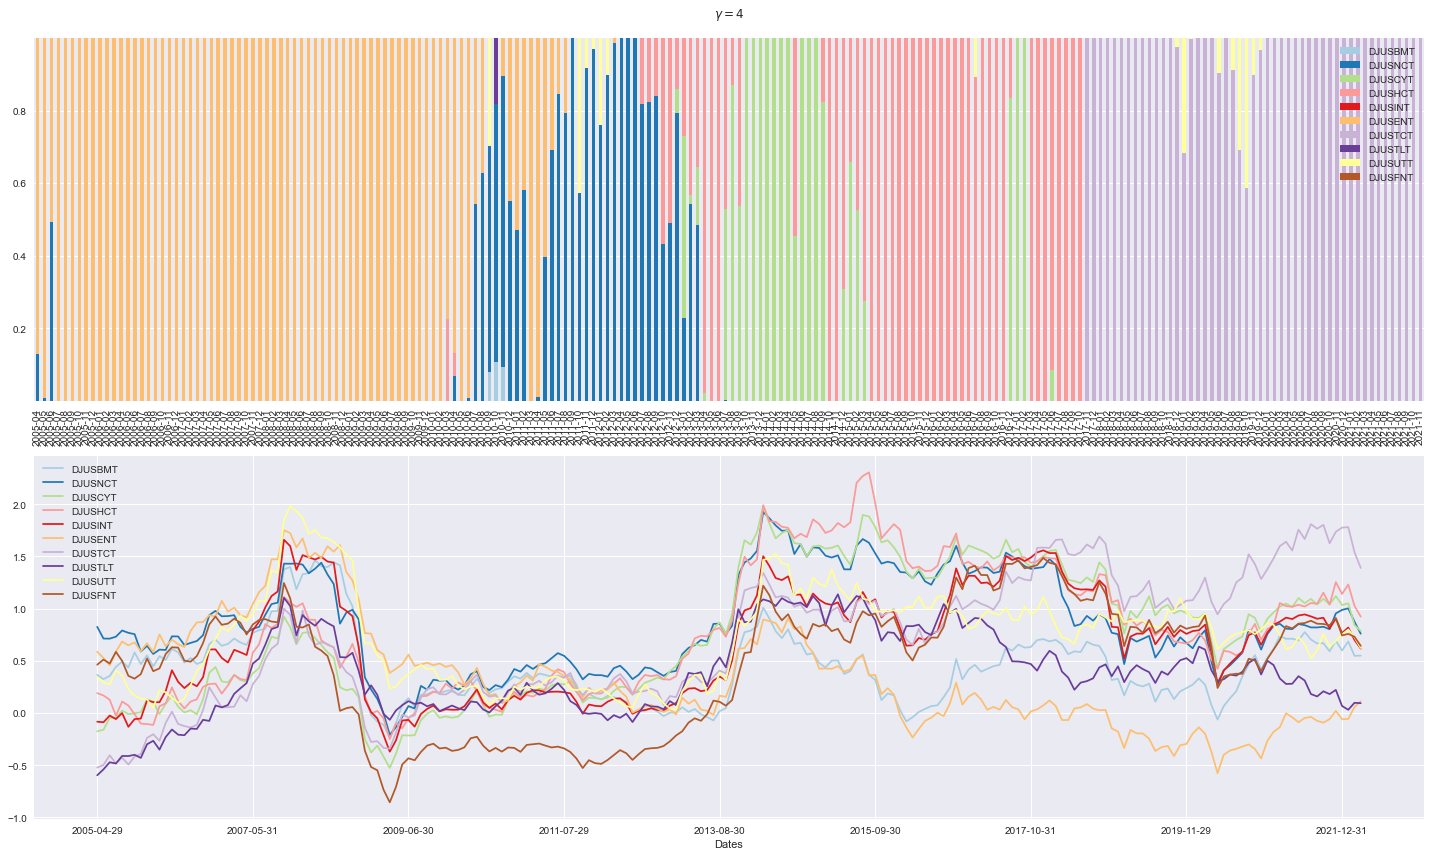

In [55]:
fig, axes = plt.subplots(ncols = 1, nrows = 2, figsize = (20, 12))
code = "us"
gamma_op = 4
b_weight = 1
weights = pd.read_csv(r".\weights\{}_quadprog_{:.0f}_{:.0%}.csv".format(code, gamma_op, b_weight),index_col=0)
weights.plot(kind='bar', stacked=True, title="$\gamma = {} $\n".format(gamma_op), colormap='Paired', ax = axes[0])
sectors = pd.read_csv(r".\sector-rotation-data\dj_sectors_monthly.csv", index_col=0)
annual_ret = lambda x: (x + 1).prod() ** (12 / len(x)) - 1
annual_vol = lambda x: np.std(x)*np.sqrt(12)
annual_sr = lambda x: annual_ret(x)/annual_vol(x)
sr_ts = sectors.rolling(window = 60, min_periods = 60).apply(annual_sr).shift(1).dropna()
sr_ts.plot(ax = axes[1], colormap='Paired')
axes[1].set_xlim = [sr_ts.index[0], sr_ts.index[-1]]
fig.tight_layout()

In [6]:
%%cmd
jupyter nbconvert --to slides sector_allocation.ipynb

Microsoft Windows [版本 10.0.19044.1586]
(c) Microsoft Corporation。保留所有权利。

C:\Users\Qianhua Zh\Desktop\AIFT\sector-rotation>jupyter nbconvert --to slides sector_allocation.ipynb
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer

[NbConvertApp] WARNING | pattern 'sector_allocation.ipynb' matched no files
